<a href="https://colab.research.google.com/github/Soham1729/Deep-Learning/blob/main/Soham_Pyne_MDS202148_Assignment_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variational Autoencoder on Fashion MNIST dataset

#### Necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as fun
import torch.nn as nn 
import torch.utils.data
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):   
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

#### Loading the dataset

In [4]:
# train_df = pd.read_csv('archive/fashion-mnist_train.csv')
# test_df = pd.read_csv('archive/fashion-mnist_test.csv')

#### Making Pytorch compatible

In [5]:
# labels_tensor = torch.tensor(train_df.label.values)
# image_tensor = torch.tensor(train_df.iloc[:,1:].values)

In [6]:
# len(labels_tensor),len(image_tensor)

#### Making a dataloader class

In [7]:
# Define data loading step

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=img_transform),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=img_transform),
    batch_size=32, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



#### Loss function

In [8]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

#### Code for VAE

In [9]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d #latent dimension
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # we have mean and variance, each is d-dim vector
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img

#### Training the VAE

====> Test set loss: 534.8126


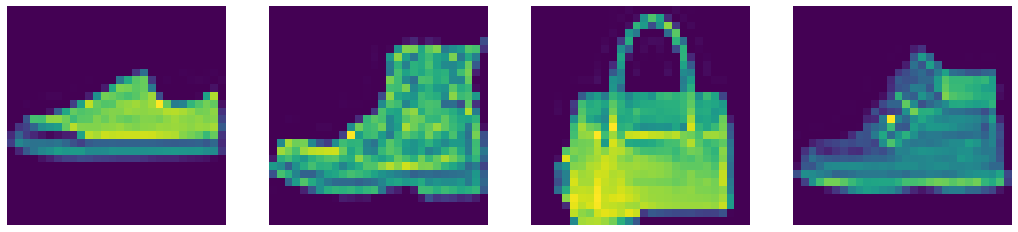

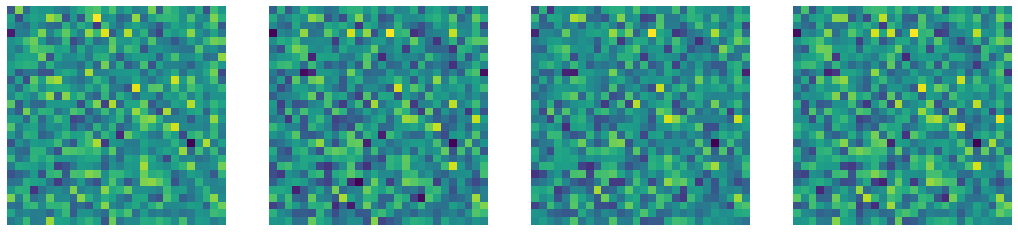

====> Epoch: 1 Average loss: 118.4992
====> Test set loss: 77.4328


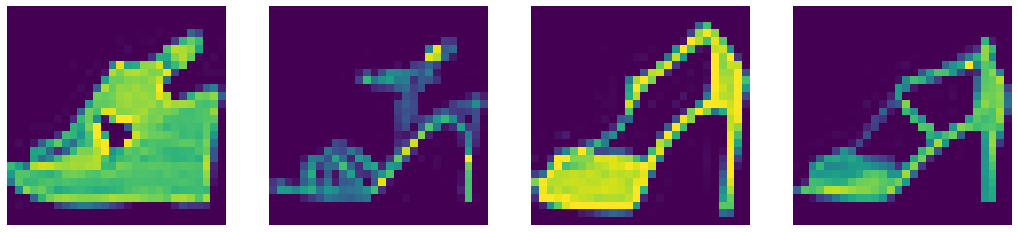

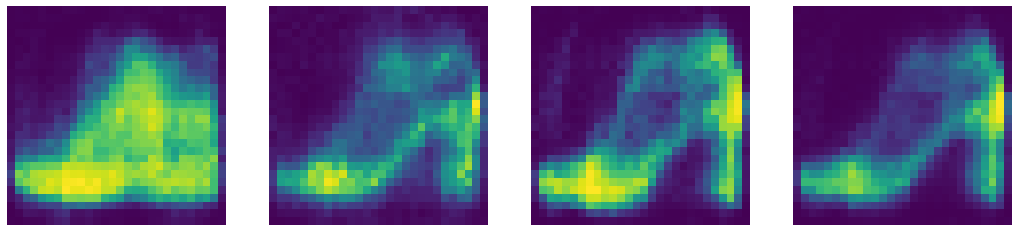

====> Epoch: 2 Average loss: 80.3487
====> Test set loss: 69.5498


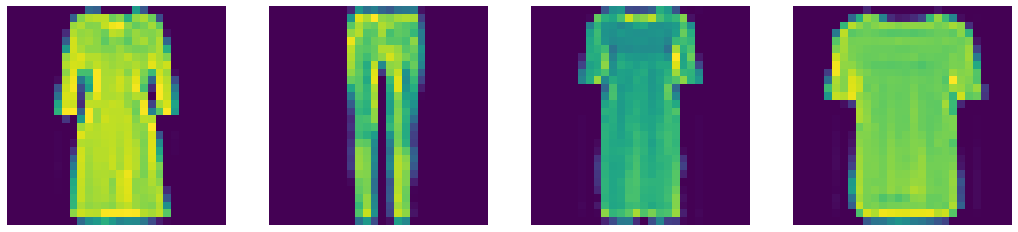

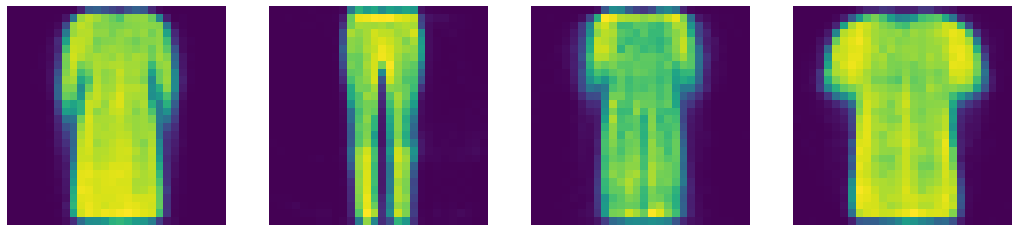

====> Epoch: 3 Average loss: 74.7882
====> Test set loss: 66.1910


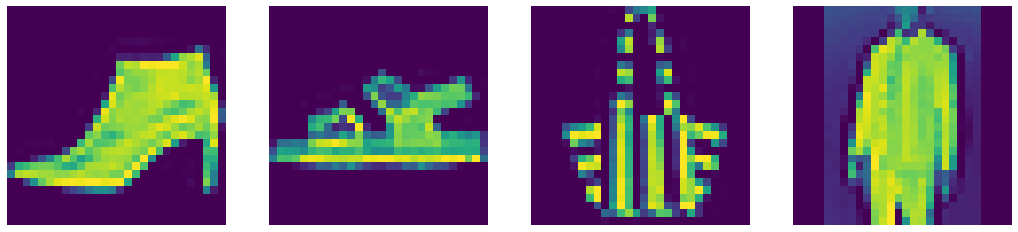

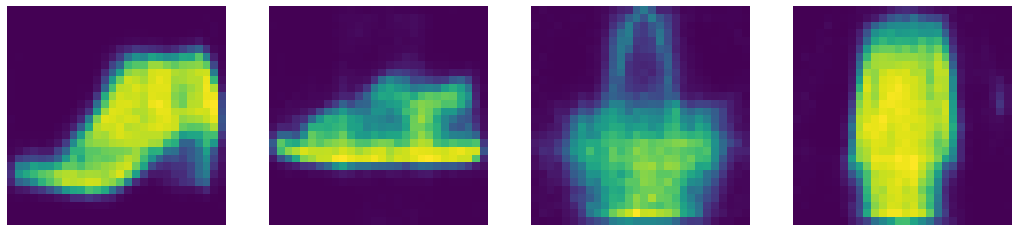

====> Epoch: 4 Average loss: 71.9103
====> Test set loss: 64.1836


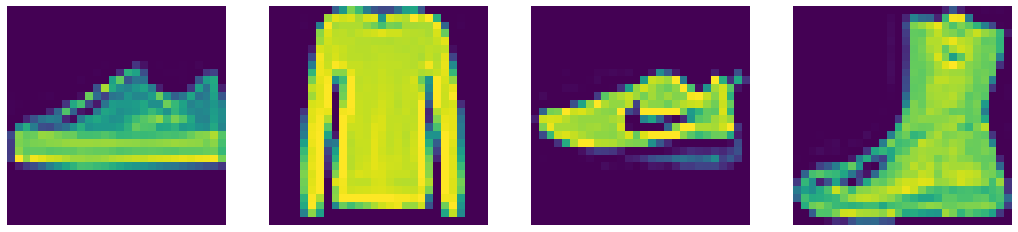

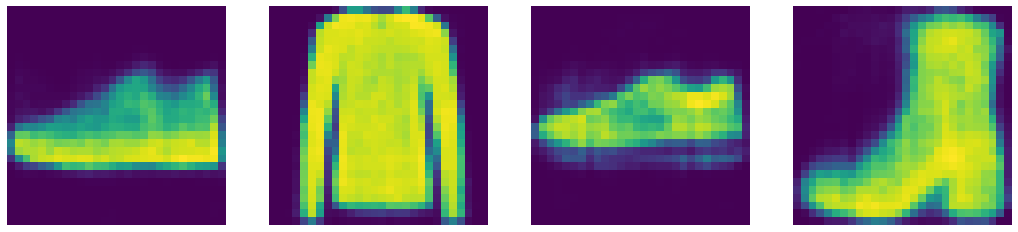

====> Epoch: 5 Average loss: 70.2459
====> Test set loss: 62.2593


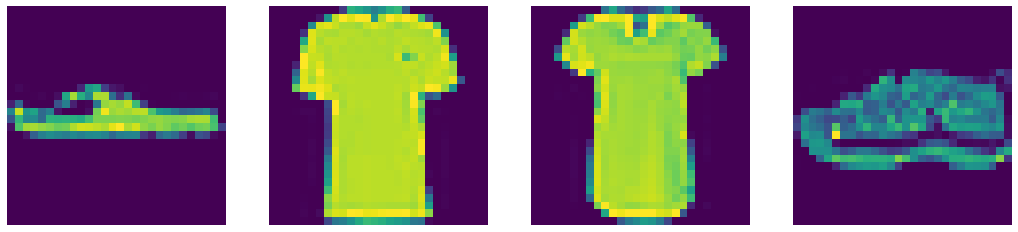

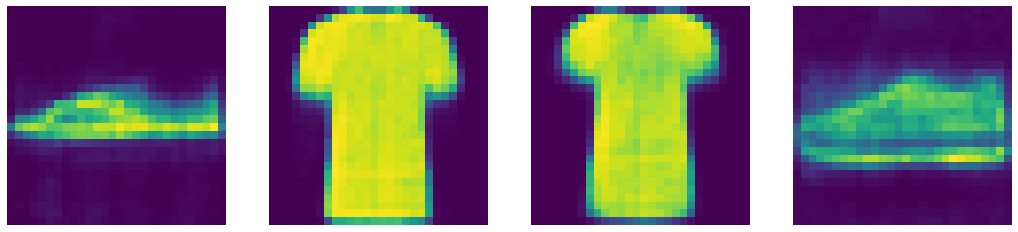

In [10]:
latent_dim=20
model = VAE(latent_dim).to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 5
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 4)

## GAN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
#import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [12]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [46]:
transform_img = transforms.Compose([
        transforms.Resize(32),  
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])

batch_size = 32

In [42]:
def get_dataloader(batch_size, transforms):
    
    data_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=True, download=True, transform=transforms),batch_size=batch_size, shuffle=True)

    return data_loader

In [43]:
train_loader_GAN = get_dataloader(batch_size,transform_img)

In [44]:
print(len(train_loader_GAN))

1875


In [47]:
img,_ = next(iter(train_loader_GAN))
# fig = plt.figure(figsize=(30, 7))
# plot_size=30 # gonna plot 30 images only
# for idx in np.arange(plot_size):
#     ax = fig.add_subplot(3, int(plot_size/3), idx+1, xticks=[], yticks=[])
#     npimg = img[idx].numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [48]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

In [49]:
img = img[5]
print('Before scaling min: ', img.min())
print('Before scaling max: ', img.max())

scaled_img = scale_images(img)

print('After Scaling Min: ', scaled_img.min())
print('After Scaling Max: ', scaled_img.max())

Before scaling min:  tensor(0.)
Before scaling max:  tensor(0.9020)
After Scaling Min:  tensor(-1.)
After Scaling Max:  tensor(0.8039)


### Discriminator

In [21]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [22]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(1, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*2*4)
        
        x = self.fc(x)
        
        
        return x

### Generator

In [23]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [24]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)
        
        
        return x

In [25]:
def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [50]:
d_conv_dim = 64
g_conv_dim = 128
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


In [51]:
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [52]:
# let's look at our generator model
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


### Training the model

In [53]:
lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2)) # for generator

In [54]:
use_gpu = torch.cuda.is_available()

In [55]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [56]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader_GAN):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [57]:
n_epochs = 4
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/    4] | d_loss: 7.2157 | g_loss: 1.8375
Epoch [    1/    4] | d_loss: 0.0110 | g_loss: 9.6923
Epoch [    1/    4] | d_loss: 0.3006 | g_loss: 9.0282
Epoch [    1/    4] | d_loss: 0.0136 | g_loss: 13.5516
Epoch [    1/    4] | d_loss: 0.0160 | g_loss: 10.6075
Epoch [    1/    4] | d_loss: 0.0016 | g_loss: 10.3207
Epoch [    1/    4] | d_loss: 0.0024 | g_loss: 12.2835
Epoch [    1/    4] | d_loss: 0.0269 | g_loss: 8.9823
Epoch [    1/    4] | d_loss: 0.0015 | g_loss: 12.8798
Epoch [    1/    4] | d_loss: 0.0036 | g_loss: 11.9879
Epoch [    1/    4] | d_loss: 0.0094 | g_loss: 12.6164
Epoch [    1/    4] | d_loss: 0.0394 | g_loss: 10.8569
Epoch [    1/    4] | d_loss: 0.0023 | g_loss: 12.2806
Epoch [    1/    4] | d_loss: 0.0020 | g_loss: 11.0578
Epoch [    1/    4] | d_loss: 0.0024 | g_loss: 11.0371
Epoch [    1/    4] | d_loss: 0.0032 | g_loss: 11.0876
Epoch [    1/    4] | d_loss: 0.0007 | g_loss: 11.3749
Epoch [    1/    4] | d_loss: 0.0023 | g_loss: 13.6032
Epoch [    1/ 

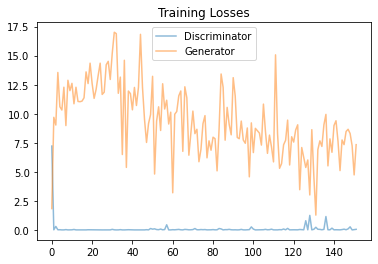

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [62]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32)))

In [63]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

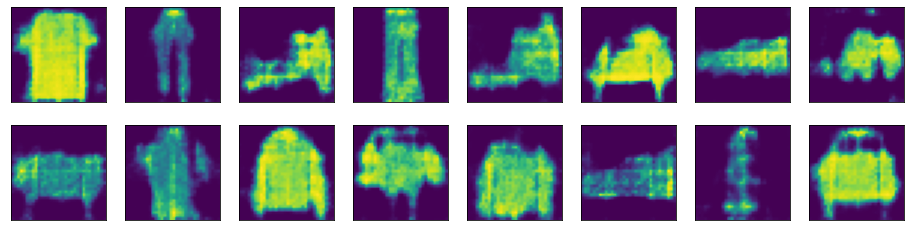

In [64]:
_ = view_samples(-1, samples)